In [1]:
from keras.layers import Conv3D,Conv2D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.layers import Add, Activation, AveragePooling2D, MaxPooling2D, ReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
import plotly.express as px
import seaborn as sns

plt.style.use('Solarize_Light2')

init_notebook_mode(connected=True)
%matplotlib inline

In [44]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2
windowSize = 25
S = windowSize
K = 9
output_units = 9

#### Importation des donnés, utilisation de PCA, aplatir les données, et suppression de la classe 0

In [87]:
X, y = loadData(dataset)
X,pca = applyPCA(X,numComponents=10)

X = X[y>0]
y = y[y>0]
X_flat = X.reshape(-1, X.shape[-1])
y_flat = y.reshape(-1)
y_flat = to_categorical(y_flat)
y_flat = y_flat[:,1:]

print("X_flat_shape: ", X_flat.shape)
print("y_flat_shape: ", y_flat.shape)


X_flat_shape:  (42776, 10)
y_flat_shape:  (42776, 9)


#### Creation, compilation, et entrainement du premier modele : 

In [93]:
X_flat_train, X_flat_test, y_flat_train, y_flat_test = splitTrainTestSet(X_flat, y_flat, test_ratio)

def first_model_without_image_cubes(shape, classes = output_units):
    X_input = Input(shape=shape)    
    X = Dense(512, activation='relu', name='fc0')(X_input)
    X = Dropout(0.5)(X)
    X = Dense(512, activation='relu', name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    model = Model(inputs = X_input, outputs = X, name='first_model')
    return model
first_model_without_image_cubes = first_model_without_image_cubes(shape=(X_flat_train.shape[1], ))

adam = Adam(learning_rate=0.001)
first_model_without_image_cubes.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "first_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = first_model_without_image_cubes.fit(x=X_flat_train, y=y_flat_train, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6954 - loss: 0.9121
Epoch 1: accuracy improved from -inf to 0.78679, saving model to first_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6961 - loss: 0.9098
Epoch 2/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8636 - loss: 0.3620
Epoch 2: accuracy improved from 0.78679 to 0.86669, saving model to first_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8637 - loss: 0.3618
Epoch 3/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8807 - loss: 0.3127
Epoch 3: accuracy improved from 0.86669 to 0.88133, saving model to first_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8807 - loss: 0.3126
Epoch 4/100
129/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8901 - loss: 0.2925
Epoch 4: accuracy improved from 0.88133 to 0.89150, saving model to first_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8901 - loss: 0.2923
Epoch 5/1

#### Récuperation des meilleurs poids pour l'évaluation

In [94]:
first_model_without_image_cubes.load_weights(filepath)
first_model_without_image_cubes.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


#### Première évaluation : Confusion matrix

In [95]:
Y_pred_test = first_model_without_image_cubes.predict(X_flat_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_flat_test, axis=1), y_pred_test)
print(classification)

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1326
           1       0.95      0.98      0.96      3730
           2       0.83      0.81      0.82       420
           3       0.96      0.95      0.96       613
           4       1.00      1.00      1.00       269
           5       0.92      0.82      0.87      1006
           6       0.92      0.88      0.90       266
           7       0.90      0.87      0.88       737
           8       1.00      0.99      1.00       189

    accuracy                           0.94      8556
   macro avg       0.94      0.92      0.93      8556
weighted avg       0.94      0.94      0.94      8556



#### établissement du rapport d'évaluation du premier modéle : 

In [96]:
classification, conf, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(first_model_without_image_cubes, X_flat_test,y_flat_test,dataset)
classification = str(classification)
confusion = str(conf)
file_name = "classification_report_first_model_without_image_cubes.txt"

with open(file_name, 'w') as x_file:
    x_file.write('DATASET ={}'.format(dataset))
    x_file.write('\n')    
    x_file.write('Test ratio ={}'.format(test_ratio))
    x_file.write('\n')
    x_file.write('Window size ={}'.format(windowSize))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9319 - loss: 0.1760


#### Confusion Matrix : 

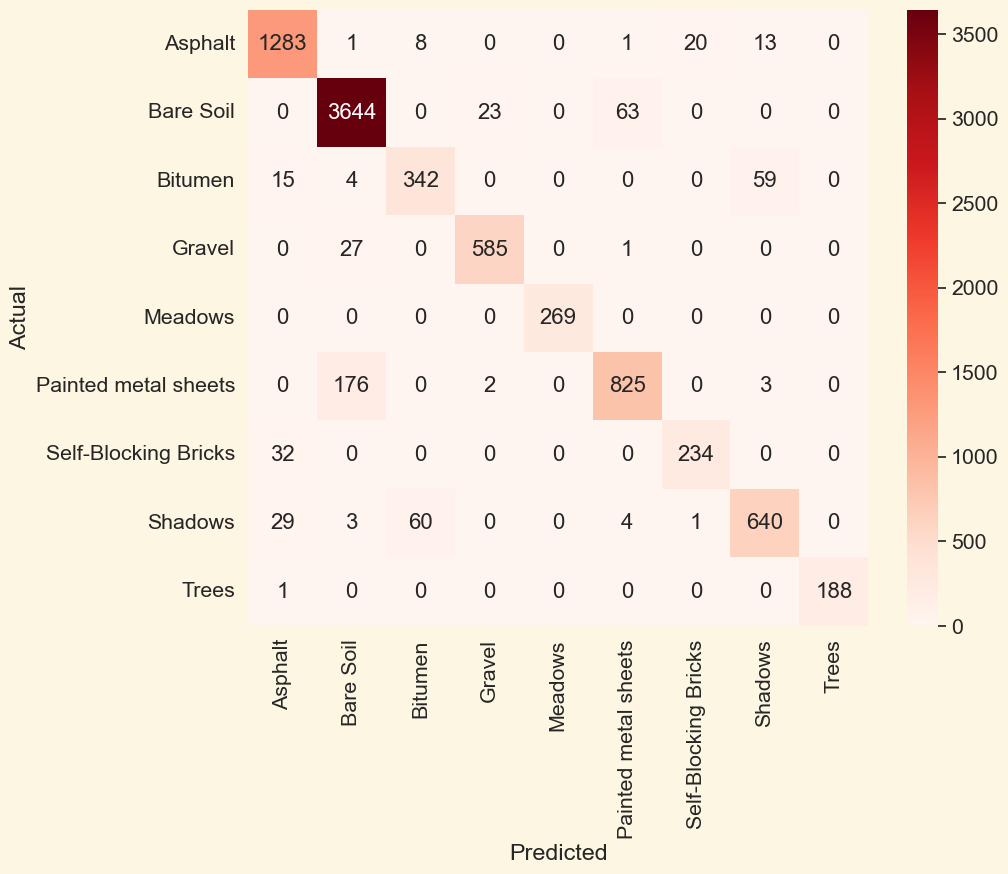

In [97]:

names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']


df_cm = pd.DataFrame(conf, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=1200)